In [1]:
import numpy as np
import h5py
import numpy as np
from scipy.integrate import solve_ivp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import torch
import matplotlib.pyplot as plt

(309700, 75)
torch.Size([250000, 75])
torch.Size([250000, 75])
torch.Size([50000, 75])
torch.Size([50000, 75])


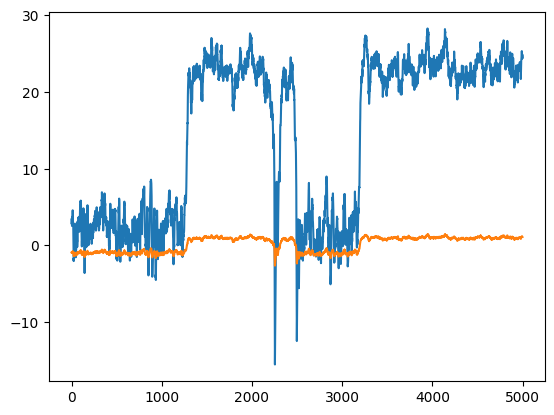

In [2]:
# Init pack

import numpy as np
import h5py
import numpy as np
from scipy.integrate import solve_ivp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import torch
import matplotlib.pyplot as plt

psi = np.load('/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy')

# Pre-processing

lead = 1

trainN = 250000
valN = 50000
index = 63

psi = psi[:,1,:]
plt.plot(psi[0:5000,63])
print(psi.shape)
mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
psi = (psi - mean_psi) / std_psi

psi_train_input = torch.tensor(psi[0:trainN,:])
psi_train_label =  torch.tensor(psi[lead:trainN+lead,:])


# # Make sure input and label lengths match
# assert psi_train_input.shape[0] == psi_train_label.shape[0], "Input and label length mismatch"

# #shuffle and map indices\
# valid_indices = np.arange(0, trainN - lead)
# np.random.seed(42)  # Optional for reproducibility
# shuffled_indices = np.random.permutation(valid_indices)
# psi_train_input = torch.tensor(psi[shuffled_indices, :])
# psi_train_label = torch.tensor(psi[shuffled_indices + lead, :])


# t = shuffled_indices[0]
# print(torch.allclose(psi_train_input[0], torch.tensor(psi[t])))
# print(torch.allclose(psi_train_label[0], torch.tensor(psi[t + 1])))

psi_val_input = torch.tensor(psi[trainN:trainN+valN,:])
psi_val_label =  torch.tensor(psi[trainN+lead:trainN+valN+lead,:])

print(psi_train_input.shape)
print(psi_train_label.shape)
print(psi_val_input.shape)
print(psi_val_label.shape)
plt.plot(psi[0:5000,63])
# plt.plot(psi_val_input[0:50000,63])

In [3]:
# Define the encoder (MLP)
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        # self.fc1 = nn.Linear(75, 512)  # Input layer (2 + 2) -> Hidden layer (128)
        # self.fc2 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        # self.fc3 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        # self.fc4 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        # self.fc5 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        # self.fc6 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        # self.fc_mu = nn.Linear(512, latent_dim)  # Hidden layer (128) -> Latent space (2)
        # self.fc_logvar = nn.Linear(512, latent_dim)  # Hidden layer (128) -> Log variance (2)

    def forward(self, x):
        # x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        # x = torch.relu(self.fc2(x)) + x
        # x = torch.relu(self.fc3(x)) + x
        # x = torch.relu(self.fc4(x)) + x
        # x = torch.relu(self.fc5(x)) + x
        # # x = torch.relu(self.fc6(x)) + x
        # mu = self.fc_mu(x)
        # logvar = self.fc_logvar(x)
        return None

# Define the decoder (MLP)
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim, 512)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_output = nn.Linear(512, output_dim)  # Hidden layer (128) -> Output layer (2)

    def forward(self, z, condition):
        z = torch.cat((z, condition), dim=1)  # Concatenate latent vector and condition
        z = torch.relu(self.fc1(z))  # Activation function for hidden layer
        z = torch.relu(self.fc2(z)) + z
        z = torch.relu(self.fc3(z)) + z
        z = torch.relu(self.fc4(z)) + z
        z = torch.relu(self.fc5(z)) + z
        z = torch.relu(self.fc6(z)) + z
        output = self.fc_output(z)
        return output

# Define the VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, output_dim, condition_dim)

    def decode(self, z, condition):
        return self.decoder(z, condition)

    def forward(self, z, condition,):
        z = torch.randn(z.size(0), z.size(1)).to(z.device)  # Sample from standard normal distribution
        output = self.decode(z, condition)
        return output

output_dim = 75
latent_dim = 1024
condition_dim = 75
batch_size = 1024
num_epochs = 100

In [ ]:
# Training

import datetime
import os
import math

def normalize_transition_time(slope_value, delta, transition_real):
    normalized = 1 - np.exp(-np.abs((slope_value - transition_real)) / delta)
    return normalized

def total_variation_distance(p, q):
    p = np.array(p)
    q = np.array(q)
    return 0.5 * np.sum(np.abs(p - q))

def calculate_transition_durations(y_values, upper_bound, lower_bound):
    times_between_transitions = []
    transition_start = None
    above_upper = False
    below_lower = False
    for i in range(1, len(y_values)):
        if y_values[i] < lower_bound:
            below_lower = True
            above_upper = False
        elif y_values[i] > upper_bound:
            if below_lower and transition_start is not None:
                times_between_transitions.append(i - transition_start)
                transition_start = None
            above_upper = True
            below_lower = False
        if below_lower and transition_start is None:
            transition_start = i
    return times_between_transitions

latent_dims = [144]
latent_dim = 144
kl_coefficients = [10]
num_cycles = 1
upper_bound = 53.8 / 2.8935
lower_bound = 7.41
level = 63

best_distance = float('inf')
tvd_list = []
transition_list = []
transition_list_unormalized = []

real_data = np.load(r"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy")
real_data_1d = real_data[:, 1, level]
real_durations = calculate_transition_durations(real_data_1d, upper_bound, lower_bound)
real_data_sorted = np.sort(real_durations)
transition_real = np.mean(real_data_sorted)
actual_hist, bin_edges = np.histogram(real_data[:, 1, level], bins=50, density=True)
print(f"Reference Real Data average_transition_time: {transition_real}")

tvds_by_dim_cycle = {kl: {cycle: [] for cycle in range(num_cycles)} for kl in kl_coefficients}
transitions_by_dim_cycle = {kl: {cycle: [] for cycle in range(num_cycles)} for kl in kl_coefficients}
transitions_normalized_by_dim_cycle = {kl: {cycle: [] for cycle in range(num_cycles)} for kl in kl_coefficients}
exp_by_dim_cycle = {kl: {cycle: [] for cycle in range(num_cycles)} for kl in kl_coefficients}

lat_folder = f"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_{datetime.datetime.now()}"
os.makedirs(lat_folder)

for kl_coef in kl_coefficients:
    print(f"USING KL COEF OF {kl_coef}")
    best_models = []
    best_models_saved = []
    for cycle in range(0,num_cycles):
        tvd_cycle_list = []
        transition_cycle_list = []
        transition_cycle_list_unormalized = []
        
        # Initialize the model, optimizer, and loss function
        model = ConditionalVAE(latent_dim, output_dim, condition_dim)
        model = model.cuda()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        num_epochs = 150

        folder = f"{lat_folder}/model_at_{cycle}_with_kl_{kl_coef}"
        os.makedirs(folder)
        subfolders = ['timeseries', 'expo_fit', '2D', 'summary']

        # Create each subdirectory inside the main folder
        for subfolder in subfolders:
            path = os.path.join(folder, subfolder)
            os.mkdir(path)
            print(f"Created subfolder: {path}")

        # from torchsummary import summary

        # summary(model, input_size = [(128, 1, 75), (128, 75)])
        # Train the model
        for epoch in range(num_epochs):
            z_train = torch.zeros([batch_size,latent_dim])
            z_val = torch.zeros([batch_size,latent_dim])
            model.train()
            for batch in range (0, trainN, batch_size):
                
                # end = min(batch + batch_size, trainN)
                # indices = np.random.permutation(np.arange(start=batch, step=1,stop=end))
                # input_batch, label_batch = psi_train_input[indices], psi_train_label[indices]
                input_batch = psi_train_input[batch:batch + batch_size,:]
                label_batch = psi_train_label[batch:batch + batch_size,:]

                optimizer.zero_grad()

                z_train = torch.randn_like(z_train)
                z_train = z_train[:input_batch.shape[0],:]

                output = model(z_train.float().cuda(), input_batch.float().cuda())

                # Reconstruction loss
                reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
                
                # Total loss
                loss = reconstruction_loss

                loss.backward()
                optimizer.step()

            print(f'''Epoch {epoch+1}, 
                Reconstrunction Loss: {loss.item()}''')

            # Validation Loss
            for batch in range (0, valN, batch_size):

                # end = min(batch + batch_size, valN)
                # indices = np.random.permutation(np.arange(start=batch, step=1,stop=end))
                # input_batch, label_batch = psi_val_input[indices], psi_val_label[indices]
                input_batch = psi_val_input[batch:batch + batch_size,:]
                label_batch = psi_val_label[batch:batch + batch_size,:]
                
                z_val = torch.randn_like(z_val)
                z_val = z_val[:input_batch.shape[0],:]

                output = model(z_val.float().cuda(), input_batch.float().cuda())

                # Reconstruction loss
                val_reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
                
                # Total loss
                val_loss = val_reconstruction_loss
                # Print both reconstruction_loss and kl_loss

            print(f'''
                Validation Reconstrunction Loss: {val_loss.item()}''')
            
            # Inference

            initial_cond = torch.reshape(torch.tensor(psi[0,:]), [1, 75])
            time_step = 30000
            num_ens = 1
            pred = np.zeros ([time_step, 75, num_ens])

            for k in range (0, time_step):

                for ens in range (0, num_ens):
                    if (k ==0):
                        z = torch.randn_like(z)
                        print(z.shape, initial_cond.shape)
                        y = (model.decode(z.float().cuda(),initial_cond.float().cuda())).detach().cpu().numpy()
                        pred[k,:,ens] = y
                        y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                        initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])

                    else:
                        select_ens = np.random.randint(0,num_ens,1)
                        z = torch.randn_like(z)
                        y = (model.decode(z.float().cuda(),torch.reshape(torch.tensor(pred[k-1,:,select_ens]),[1,75]).float().cuda())).detach().cpu().numpy()
                        pred[k,:, ens] = y
                        y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                        initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])

            # Denormalize final preds
            print(std_psi[:, 63])
            pred_mean = pred * std_psi[:, 63] + mean_psi[:, 63]

            # Denormalize test labels
            actual_values = psi_train_label[:time_step, 63] * std_psi[:, 63] + mean_psi[:, 63]
            print(actual_values)
            
            real_data_1d = real_data[:30000, 0, 63]  # Now shape is (309700,)
            predictions_1d = pred_mean[:, 63]  # shape (300000,)

            plt.figure(figsize=(20,8))
            plt.plot(pred_mean[0:30000,63],'r')
            plt.plot(real_data[0:30000, 0, 63])
            plt.grid(True)
            plt.title(f"Predictions vs Actual | Epoch {epoch}")
            save_path = os.path.join(folder, "timeseries")
            save_path = os.path.join(save_path, f"timeseries_plot_{epoch}.png")
            plt.savefig(save_path)
            plt.xlabel('Time Step')
            plt.ylabel('Zonal Wind Value')
            plt.legend(['Predictions', 'Actual'])
            plt.tight_layout()
            plt.show()
            
            # Function to calculate transition durations
            def calculate_transition_durations(y_values, upper_bound, lower_bound):
                times_between_transitions = []
                transition_start = None
                above_upper = False
                below_lower = False

                for i in range(1, len(y_values)):
                    if y_values[i] < lower_bound:  
                        below_lower = True
                        above_upper = False
                    elif y_values[i] > upper_bound:  
                        if below_lower and transition_start is not None:
                            times_between_transitions.append(i - transition_start)
                            transition_start = None  
                        above_upper = True
                        below_lower = False

                    if below_lower and transition_start is None:
                        transition_start = i

                return times_between_transitions
            
            predictions_1d = pred_mean[:, level, 0]
            pred_durations = calculate_transition_durations(predictions_1d, upper_bound, lower_bound)
            print(pred_durations)
            pred_hist, _ = np.histogram(predictions_1d, bins=bin_edges, density=True)

            # === PREDICTIONS CCDF AND FIT ===
            exponential_fit_pred = 0

            # if len(pred_durations) > 0:
            transition_pred = np.mean(pred_durations)
            transition_cycle_list.append(normalize_transition_time(transition_pred, 1000, transition_real))
            transition_cycle_list_unormalized.append(transition_pred)
            transitions_by_dim_cycle[kl_coef][cycle].append(transition_pred)
            transitions_normalized_by_dim_cycle[kl_coef][cycle].append(normalize_transition_time(transition_pred, 1000, transition_real))

            tvd = total_variation_distance(pred_hist, actual_hist)
            tvd_cycle_list.append(tvd)
            tvds_by_dim_cycle[kl_coef][cycle].append(tvd)

            distance = np.sqrt(tvd ** 2 + (normalize_transition_time(transition_pred, 1000, transition_real)) ** 2)

            print(f"Epoch {epoch+1}: TVD = {tvd:.6f}, Transition_Difference = {transition_pred-transition_real:.6f}, Combined Distance = {distance:.6f}")
            torch.save(model.state_dict(), f"{folder}/model_at_epoch{epoch}")

            if distance < best_distance:
                best_distance = distance
                torch.save(model.state_dict(), f"{folder}/best_model_combined_distance.pth")
                print("New best model saved based on TVD + transition difference distance.")
            # else:
            #     print("No transitions detected in predictions.")
            #     transitions_by_dim_cycle[kl_coef][cycle].append(np.nan)
            #     tvds_by_dim_cycle[kl_coef][cycle].append(np.nan)
            #     tvd_cycle_list.append(np.nan)
            #     transition_cycle_list.append(np.nan)
            #     transition_cycle_list_unormalized.append(np.nan)


            # Plot labels and formatting

            x_line_real = np.linspace(min(real_data_sorted), max(real_data_sorted), 100)
            exponential_fit_real = 1/np.mean(real_data_sorted)
            y_values_real = exponential_fit_real*x_line_real
            plt.plot(x_line_real, y_values_real, 'b-', label=f'Real Exp Fit (slope={exponential_fit_real:.4f})', linewidth=2)

            if len(pred_durations) > 0:
                x_line_pred = np.linspace(min(pred_durations), max(pred_durations), 100)
                exponential_fit_pred = 1/np.mean(pred_durations)
                y_values_pred = exponential_fit_pred*x_line_pred
                plt.plot(x_line_pred, y_values_pred, 'r-', label=f'Pred Exp Fit (slope={exponential_fit_pred:.4f})', linewidth=2)
                exp_by_dim_cycle[kl_coef][cycle].append(exponential_fit_pred)

            plt.xlabel('Time Duration (Steps)')
            plt.ylabel('Exponential Fit')
            plt.title('Exponential Fit of Time Between B->A and A->B Transitions (Exponential Fit)')
            plt.yscale("linear")  # y-axis log scale
            plt.xscale("linear")  # x-axis linear scale
            plt.grid()
            plt.legend()
            plt.tight_layout()
            save_path = os.path.join(folder, "expo_fit")
            save_path = os.path.join(save_path, f"expo_fit_plot_{epoch}.png")
            plt.savefig(save_path)
            plt.show()

            plt.figure(figsize=(12, 6))
            plt.plot(tvd, transition_pred, 'o-', label=f'Cycle {cycle}')
            plt.xlabel("Total Variation Distance")
            plt.ylabel("Average Transition Time")
            plt.axhline(y=transition_real, color='r', linestyle='--', label='Real Data')
            plt.ylim(0.1,2000)
            plt.xlim(0, 1)
            plt.title("TVD vs. Avg Transition Time per Epoch")
            plt.grid(True)
            save_path = os.path.join(folder, "2D")
            save_path = os.path.join(save_path, f"2D_plot_{epoch}.png")
            plt.savefig(save_path)
            plt.show()
            
            if epoch == num_epochs - 1:  # Last epoch of last cycle for this dimension
                # Plot TVDs with cycles overlapped
                plt.figure(figsize=(10, 6))
                for c in range(num_cycles):
                    plt.plot(tvds_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                
                plt.xlabel('Epoch within Cycle')
                plt.ylabel('Total Variation Distance')
                plt.title(f'TVD Progress (KL Coefficient={kl_coef})')
                plt.grid(True)
                plt.legend()
                save_path = os.path.join(folder, "summary")
                save_path = os.path.join(save_path, f"tvd_plot_all_cycles.png")
                plt.savefig(save_path)
                plt.show()
                
                # Plot Exponential Fits with cycles overlapped
                plt.figure(figsize=(10, 6))
                for c in range(num_cycles):
                    plt.plot(transitions_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                
                plt.axhline(y=transition_real, color='r', linestyle='--', label='Real Data')
                plt.xlabel('Epoch within Cycle')
                plt.ylabel('Average Transition Value')
                plt.ylim(0.1,2000)
                plt.title(f'Average Transition Progress (KL Coefficient={kl_coef})')
                plt.grid(True)
                plt.legend()
                save_path = os.path.join(folder, "summary")
                save_path = os.path.join(save_path, f"transition_plot_all_cycles.png")
                plt.savefig(save_path)
                plt.show()

                plt.figure(figsize=(10, 6))
                for c in range(num_cycles):
                    plt.plot(exp_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                
                plt.axhline(y=exponential_fit_real, color='r', linestyle='--', label='Real Data')
                plt.xlabel('Epoch within Cycle')
                plt.ylabel('Exponential Fit Value')
                plt.title(f'Exponential Fit Progress (KL Coefficient={kl_coef})')
                plt.grid(True)
                plt.legend()
                save_path = os.path.join(folder, "summary")
                save_path = os.path.join(save_path, f"exponential_fit_plot_all_cycles.png")
                plt.savefig(save_path)
                plt.show()
                
                # Plot TVD and 1/average transition time per epoch
                plt.figure(figsize=(12, 6))
                plt.scatter(tvd_cycle_list, transition_cycle_list, c=range(len(tvd_cycle_list)), cmap='viridis')
                plt.colorbar(label='Epoch')
                plt.xlabel("Total Variation Distance")
                plt.ylabel("Average Transition Time")
                plt.title("TVD vs. Avg Transition Time per Epoch")
                plt.grid(True)
                save_path = os.path.join(folder, "summary")
                save_path = os.path.join(save_path, f"tvd_vs_transition_plot_all_cycles.png")
                plt.savefig(save_path)
                plt.show()
                
                # If this is the last latent dimension, create master graphs with all dimensions
                if kl_coef == kl_coefficients[-1] and cycle == num_cycles - 1:
                    # Create a master folder for overlapping graphs
                        
                        # Plot TVDs with cycles overlapped
                    plt.figure(figsize=(10, 6))
                    for c in range(num_cycles):
                        plt.plot(tvds_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                    
                    plt.xlabel('Epoch within Cycle')
                    plt.ylabel('Total Variation Distance')
                    plt.title(f'TVD Progress (KL Coefficient={kl_coef})')
                    plt.grid(True)
                    plt.legend()
                    save_path = os.path.join(lat_folder, f"tvd_plot_all_cycles.png")
                    plt.savefig(save_path)
                    plt.show()
                    
                    # Plot Exponential Fits with cycles overlapped
                    plt.figure(figsize=(10, 6))
                    for c in range(num_cycles):
                        plt.plot(transitions_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                    
                    plt.axhline(y=transition_real, color='r', linestyle='--', label='Real Data')
                    plt.xlabel('Epoch within Cycle')
                    plt.ylabel('Average Transition Value')
                    plt.ylim(0.1,2000)
                    plt.title(f'Average Transition Progress (KL Coefficient={kl_coef})')
                    plt.grid(True)
                    plt.legend()
                    save_path = os.path.join(lat_folder, f"transition_plot_all_cycles.png")
                    plt.savefig(save_path)
                    plt.show()

                    plt.figure(figsize=(10, 6))
                    for c in range(num_cycles):
                        plt.plot(exp_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                    
                    plt.axhline(y=exponential_fit_real, color='r', linestyle='--', label='Real Data')
                    plt.xlabel('Epoch within Cycle')
                    plt.ylabel('Exponential Fit Value')
                    plt.title(f'Exponential Fit Progress (KL Coefficient={kl_coef})')
                    plt.grid(True)
                    plt.legend()
                    save_path = os.path.join(lat_folder, f"exponential_fit_plot_all_cycles.png")
                    plt.savefig(save_path)
                    plt.show()
                    
                    # Plot TVD and 1/average transition time per epoch
                    plt.figure(figsize=(12, 6))
                    plt.scatter(tvd_cycle_list, transition_cycle_list, c=range(len(tvd_cycle_list)), cmap='viridis')
                    plt.colorbar(label='Epoch')
                    plt.xlabel("Total Variation Distance")
                    plt.ylabel("Average Transition Time")
                    plt.title("TVD vs. Avg Transition Time per Epoch")
                    plt.grid(True)
                    save_path = os.path.join(lat_folder, f"tvd_vs_transition_plot_all_cycles.png")
                    plt.savefig(save_path)
                    plt.show()

            torch.save(model.state_dict(), f"{folder}/checkpoint_{epoch+1}")
            print(f"Model weights saved to {folder} with point {epoch+1}.")
        
            tvd_list.append(tvd_cycle_list)
            transition_list.append(transition_cycle_list)
            transition_list_unormalized.append(transition_cycle_list_unormalized)

        # Save the model after each cycle
        index = -1
        best_distance = float('inf')
        for i in range(0, num_cycles):
            distance = np.sqrt(tvds_by_dim_cycle[kl_coef][cycle][i] ** 2 + transitions_normalized_by_dim_cycle[kl_coef][cycle][i] ** 2)
            if distance < best_distance:
                best_distance = distance
                torch.save(model.state_dict(), f"{folder}/best_model_combined_distance.pth")
                print("New best model saved based on TVD + normalized average transition value.")
                index = i
                best_models_saved.append(model.state_dict())
        best_models.append(index)


    best_model_distance = float('inf')
    for i,n in enumerate(best_models):
        distance = np.sqrt(tvds_by_dim_cycle[kl_coef][i][n] ** 2 + transitions_normalized_by_dim_cycle[kl_coef][i][n] ** 2)
        if distance < best_model_distance:
            best_model_distance = distance
            best_model = best_models_saved[i]
            where_model = (i,n)
    # Save the best model  
    coordinates = where_model
    cycle = i
    epoch = n
    torch.save(best_model, f"{lat_folder}/best_model_combined_distance.pth")
    print(f"Best model saved based on TVD + normalized average transition value with cycle {i+1} and epoch {n+1}.")